In [1]:
cd ..

/Users/sean/CloudStation/Metis/projects/project4


In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import punkt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
from src.functions import get_sents, display_topics
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pylab as plt
%matplotlib inline

In [3]:
# Get the collection of n(=1)-sentence snippets with the word 'love'
love_snippets = pd.read_pickle('./data/processed/love_snippets')

From results EDA I found that talk ID=132 and 2382 were 'outliers' after dimension reduction was performed when using CountVectorizer(binary=False).  These two talks were songs that mentioned love a lot.  By deleting them I'm trying to capture orthogonal variance in topics modeling to not be dominated by these 2 talks.

In [4]:
love_snippets.loc[[132, 2382]]

,transcript,url,sentences,n_love_sents,love
132,I’d like to dedicate this one to all the women...,https://www.ted.com/talks/vusi_mahlasela_sings...,57,12,"♫ ♫ Should I now stop singing of love, ♫ ♫ now..."
2382,(Sings) Water Boy(Guitar strum)where are you h...,https://www.ted.com/talks/rhiannon_giddens_3_s...,109,15,So I wrote a song based on some of those narra...


I'll uncomment this when I want those song talks eliminated.

In [5]:
#love_snippets.drop(labels=[132, 2382],inplace=True)

In [6]:
# Topic modeling
# Vectorize
cv1 = CountVectorizer(stop_words='english',binary=False)
cv_doc_word = cv1.fit_transform(love_snippets.love)
# Dimension Reduction
cv_lsa=[]
cv_doc_topic=[]
for i in range(2,6):
    cv_lsa.append(TruncatedSVD(i))
    cv_doc_topic.append(cv_lsa[i-2].fit_transform(cv_doc_word))
    print(int(i),'topics variance ratios:',cv_lsa[i-2].explained_variance_ratio_)

2 topics variance ratios: [0.33746694 0.04657493]
3 topics variance ratios: [0.33746694 0.04657492 0.03275802]
4 topics variance ratios: [0.33746694 0.04657493 0.032758   0.02907629]
5 topics variance ratios: [0.33746694 0.04657493 0.032758   0.0290763  0.01894743]


# The 2-Topic Result

In [7]:
display_topics(cv_lsa[0], cv1.get_feature_names(), 14)


Topic  0
love, romantic, people, just, like, loved, think, know, want, song, life, ve, laughter, fall

Topic  1
song, life, singing, sing, yes, better, everybody, smile, pregnant, fences, jumped, ignite, softly, birth


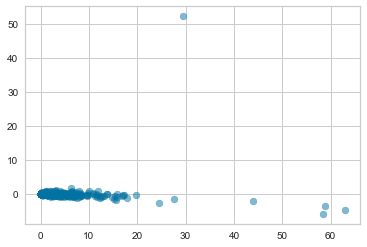

In [8]:
plt.scatter(cv_doc_topic[0][:,0],cv_doc_topic[0][:,1], alpha = 0.5);
# plt.axis([0, 60, -30, 10])

Investigating the interesting result above seemed  to show that the points in the upper right had longer snippets.  So, I decided to see if there was a relationship with the number of sentences with love in it:

Matplotlib colormaps: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

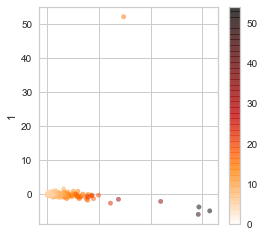

In [9]:
df=pd.DataFrame(cv_doc_topic[0])
df.plot.scatter(x=0,y=1,figsize=(4,4), alpha=0.5,\
               c=love_snippets.n_love_sents+3, cmap=plt.get_cmap('gist_heat_r'),vmin=0);

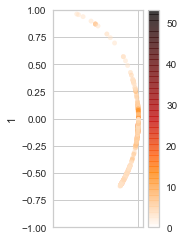

In [10]:
df = pd.DataFrame(normalize(cv_doc_topic[0]))
df.plot.scatter(x=0,y=1,figsize=(2,4), alpha=0.5,\
               c=love_snippets.n_love_sents+2, cmap=plt.get_cmap('gist_heat_r'),vmin=0)
plt.axis([0,1.05,-1,1]);
# plt.savefig("reports/figures/figure_1.png")

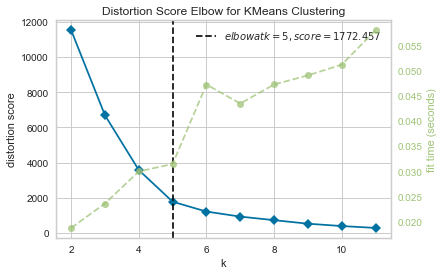

In [11]:
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(cv_doc_topic[0])        # Fit the data to the visualizer
visualizer.show();        # Finalize and render the figure

In [12]:
visualizer.elbow_value_

5

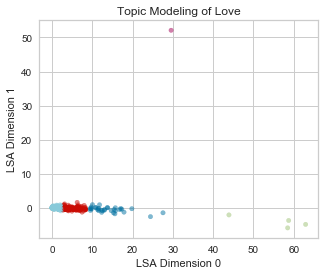

In [13]:
df=pd.DataFrame(cv_doc_topic[0],columns=['LSA Dimension 0','LSA Dimension 1'])
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=None,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
km.labels_
cmap = {0:'r',1:'g',2:'b',3:'c',4:'m',5:'y',6:'orange',7:'k',8:'aqua',9:'yellow'}
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)
df.plot.scatter(x='LSA Dimension 0',y='LSA Dimension 1',\
                figsize=(5,4), c=col, alpha = 0.5,title='Topic Modeling of Love');
# plt.axis([-1,1.05,-1,1]);

In [14]:
for i,center in enumerate(km.cluster_centers_):
    print(cmap[i],center)

r [ 4.35098395 -0.16915982]
g [56.01030345 -4.13278053]
b [13.99386415 -0.52219244]
c [ 1.12350889 -0.06467138]
m [29.55584769 52.11970268]


Getting the matrix of euclidean distances from the cluster centers: (used to work that out)

In [15]:
pd.DataFrame(pairwise_distances(km.cluster_centers_,cv_doc_topic[0]).T).head()

,0,1,2,3,4
0,2.259295,54.054592,11.884914,1.067501,58.649698
1,3.227426,55.032603,12.876141,0.059812,59.479680
2,3.349648,55.158327,12.998988,0.121409,59.467984
3,3.183088,54.988770,12.820371,0.338433,59.101940
4,9.347940,42.520991,0.650865,12.573273,54.425119


Show the snippets from the 4 (euclidean distance) closest documents:

In [16]:
doc_topic = cv_doc_topic[0]
euclidean_distances_to_centers=pd.DataFrame(pairwise_distances(km.cluster_centers_,doc_topic).T)
for i,center in enumerate(km.cluster_centers_):
    n_closest=euclidean_distances_to_centers[i].nsmallest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,cs in n_closest.iteritems():
#         print(j,cs)
        print(j,':',doc_topic[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [ 4.35098395 -0.16915982] color= r
917 : [ 4.22839932 -0.27406817] Let's start with a question: Does my dog really love me, or does she just want a treat? Well, it's easy to see that our dog really loves us, easy to see, right, what's going on in that fuzzy little head. But why is the question always do they love us? But love is not the thing that makes us human. So we started with a question: Do they love us?
1001 : [ 4.34358771 -0.35477602] And that is why, although my daughter is an athlete, she's also a huge nerd, which I love. But she knows there's someone called the Mother of Dragons, and she calls herself that and she loves it. She loves Groot. She's played by Zoe Saldana, and she is strong and smart and fast and fights like a ninja, and she is played by a beautiful black woman, and my daughter fell in love with her. Now, there will be females in the rest of these movies, but they will be sidekicks, they will be love interests, they will be members of teams.

I'll now project the doc_topic values onto the unit circle, sphere, hypersphere I.  If I don't re-cluster yet, I'm looking at the clustering results from above:

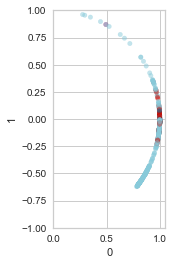

In [17]:
df = pd.DataFrame(normalize(doc_topic))
df.plot.scatter(x=0,y=1,figsize=(2,4), c=col, alpha = 0.5);
plt.axis([0,1.05,-1,1]);
# plt.savefig("reports/figures/figure_1.png")

This next cell identifies the documents closest to the cluster centers using cosine similarity.

In [18]:
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=doc_topic).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',doc_topic[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [ 4.35098395 -0.16915982] color= r
1022 : [ 0.98713131 -0.03837288] For years, I tried desperately to cultivate in my kids a love of reading.
468 : [ 2.00778177 -0.07816298] (Laughter)And I love that moment in this video, because before it became a shared experience, it was something that was maybe a little bit scary, or something that was at least confusing to her. And I love that girl's reaction so much.
493 : [ 1.00106298 -0.03900909] (Applause)Now if you'll allow me, I would love to share a one-minute film that has proven to show that a 60-sec film can be as powerful as a haiku in telling a big picture.
112 : [ 1.97479823 -0.07650886] I always live in the present — I love the present. That's Arthur Leipzig's original photograph I loved. I love being at TED.


Cluster centered at: [56.01030345 -4.13278053] color= g
928 : [ 1.04941709 -0.07740277] And the audience loved it. Audiences continue to love it because the recording of the Köln Concert is the best-sellin

Now clustering on the 

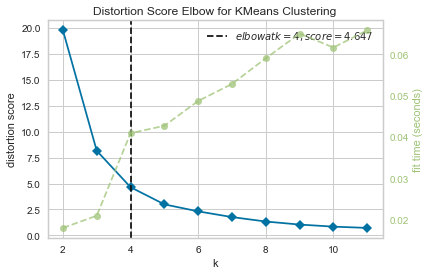

In [19]:
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(df)        # Fit the data to the visualizer
visualizer.show();                     # Finalize and render the figure

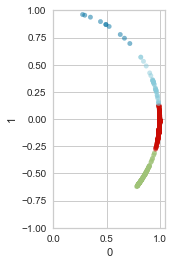

In [20]:
df = pd.DataFrame(normalize(doc_topic))
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
km.labels_
cmap = {0:'r',1:'g',2:'b',3:'c',4:'m',5:'y',6:'orange',7:'k',8:'aqua',9:'yellow'}
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)
df.plot.scatter(x=0,y=1,figsize=(2,4), c=col, alpha = 0.5);
plt.axis([0,1.05,-1,1]);
# plt.savefig("reports/figures/figure_1.png")

In [21]:
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=normalize(doc_topic)).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',normalize(doc_topic)[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [ 0.99703329 -0.05381482] color= r
371 : [ 0.99854473 -0.05392972] Now we all love to trot out these three mystic warriors as if they were born with the saint gene. "Like we're a bunch of elitist, morally-corrupt terrorist-lovers. "
315 : [ 0.99854436 -0.05393658] I love the guy who's like running away with his clasps, his hooks.
670 : [ 0.99853661 -0.05408   ] And being a theater person, what I know and love about the theater is that when the audience comes in and they suspend their disbelief, when you see men walking or women walking with a platter of grass on their heads, you know it's the savanna. I love the apparent truth of theater. I love that people are willing to fill in the blanks. And I'm one who loves high tech and low tech. I did "The Tempest" on a stage three times in the theater since 1984, '86, and I love the play. Miranda: Do you love me? And I, the king, shall love thee. (Applause) So I went from theater, doing "The Tempest" on the stage in a very

# The 3-Topic Result

In [22]:
display_topics(cv_lsa[1], cv1.get_feature_names(), 14)


Topic  0
love, romantic, people, just, like, loved, think, know, want, song, life, ve, laughter, fall

Topic  1
song, life, singing, sing, yes, better, everybody, smile, pregnant, ignite, jumped, fences, softly, birth

Topic  2
la, thank, li, janitor, want, boy, oh, lovewith, know, gave, boyis, bound, music, making


In [23]:
cv_doc_topic[1]

array([[ 2.13568489,  0.27451853, -0.03377382],
       [ 1.12386688, -0.12445939, -0.02217893],
       [ 1.00361819, -0.04554595,  0.00761779],
       ...,
       [ 0.97343028, -0.02095463, -0.01220417],
       [ 1.15439804, -0.1251897 , -0.02797579],
       [ 1.97923754, -0.07978812, -0.0291647 ]])

In [24]:
from mpl_toolkits.mplot3d import Axes3D

In [25]:
# Use this to visualize the un-projected doc-topic space:
# df = pd.DataFrame(cv_doc_topic[1])
# Use this to visualize the projected doc-topic space:
df = pd.DataFrame(normalize(cv_doc_topic[1]))

Helpful in getting started with 3D plotting:
* https://pythonprogramming.net/3d-graphing-pandas-matplotlib/
* https://matplotlib.org/3.1.1/gallery/mplot3d/scatter3d.html#sphx-glr-gallery-mplot3d-scatter3d-py
* https://stackoverflow.com/questions/47311632/jupyter-how-to-rotate-3d-graph

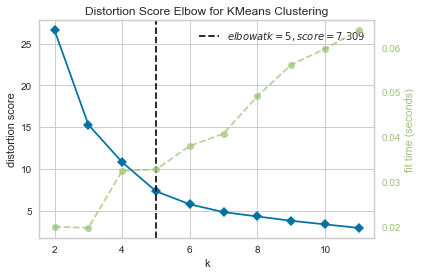

In [26]:
%matplotlib inline
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(df)                     # Fit the data to the visualizer
visualizer.show();                     # Finalize and render the figure

In [27]:
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
cluster_centers = pd.DataFrame(km.cluster_centers_)
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)

<IPython.core.display.Javascript object>


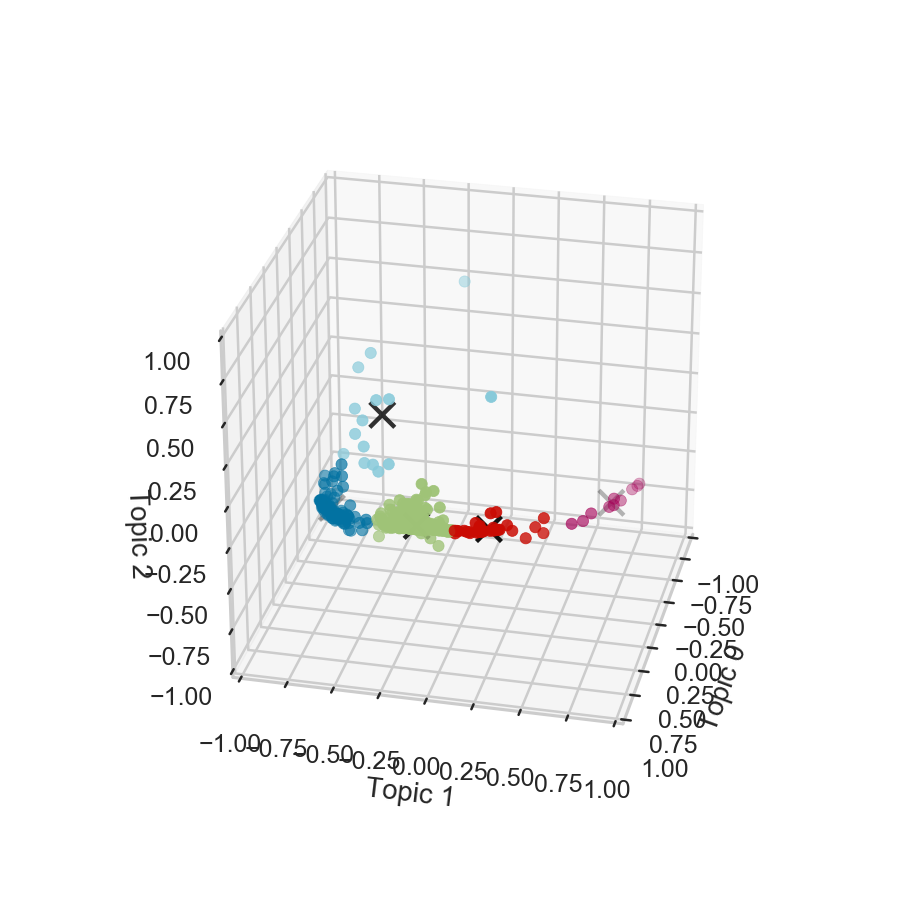

In [30]:
%matplotlib notebook
fig = plt.figure(figsize=(5,5)) #.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df[0],df[1],df[2],c=col)
ax.scatter(cluster_centers[0],cluster_centers[1],cluster_centers[2],\
           marker='x',s=100,c='k')
ax.set_xlabel('Topic 0')
ax.set_ylabel('Topic 1')
ax.set_zlabel('Topic 2')
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
fig.show();

So, what do the clusters mean?

In [31]:
doc_topic = cv_doc_topic[1]
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=normalize(doc_topic)).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',normalize(doc_topic)[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [ 0.94246114  0.31108488 -0.00804065] color= r
496 : [ 0.94805879  0.31776635 -0.0144592 ] And they'll stand before God and family and some guy her dad once did business with, and they'll vow that nothing — not abject poverty, not life-threatening illness, not complete and utter misery — will ever put the tiniest damper on their eternal love and devotion.
1094 : [ 0.94322199  0.33183746 -0.01470324] I was standing there and thinking it was the first time in my life I witnessed that you could show someone you love them completely by letting go.
685 : [0.94265168 0.33376511 0.00294147] He was 31 years old, he lived in Seattle, Washington, he was engaged to Gretchen, about to be married, she was the love of his life.
801 : [ 0.94042069  0.33984678 -0.01063419] But his life changed when he got the chance to be resettled to the United States, and he found love in a foster family and he was able to go to school, and he wanted me to share with you this proud moment when h

# The 4-Topic Result

In [32]:
display_topics(cv_lsa[2], cv1.get_feature_names(), 14)


Topic  0
love, romantic, people, just, like, loved, think, know, want, song, life, ve, laughter, fall

Topic  1
song, life, singing, sing, yes, better, everybody, smile, pregnant, jumped, fences, ignite, softly, birth

Topic  2
la, thank, li, janitor, want, boy, oh, lovewith, know, gave, boyis, bound, music, making

Topic  3
come, road, lies, way, know, hard, wait, free, tennessee, low, long, ll, called, claps


In [33]:
doc_topic = cv_doc_topic[2]
df = pd.DataFrame(normalize(cv_doc_topic[2]))

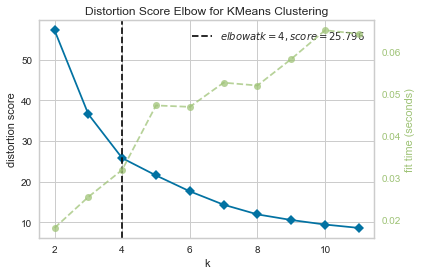

In [34]:
%matplotlib inline
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(df)                     # Fit the data to the visualizer
visualizer.show();                     # Finalize and render the figure

In [35]:
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
cluster_centers = pd.DataFrame(km.cluster_centers_)
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)

<IPython.core.display.Javascript object>


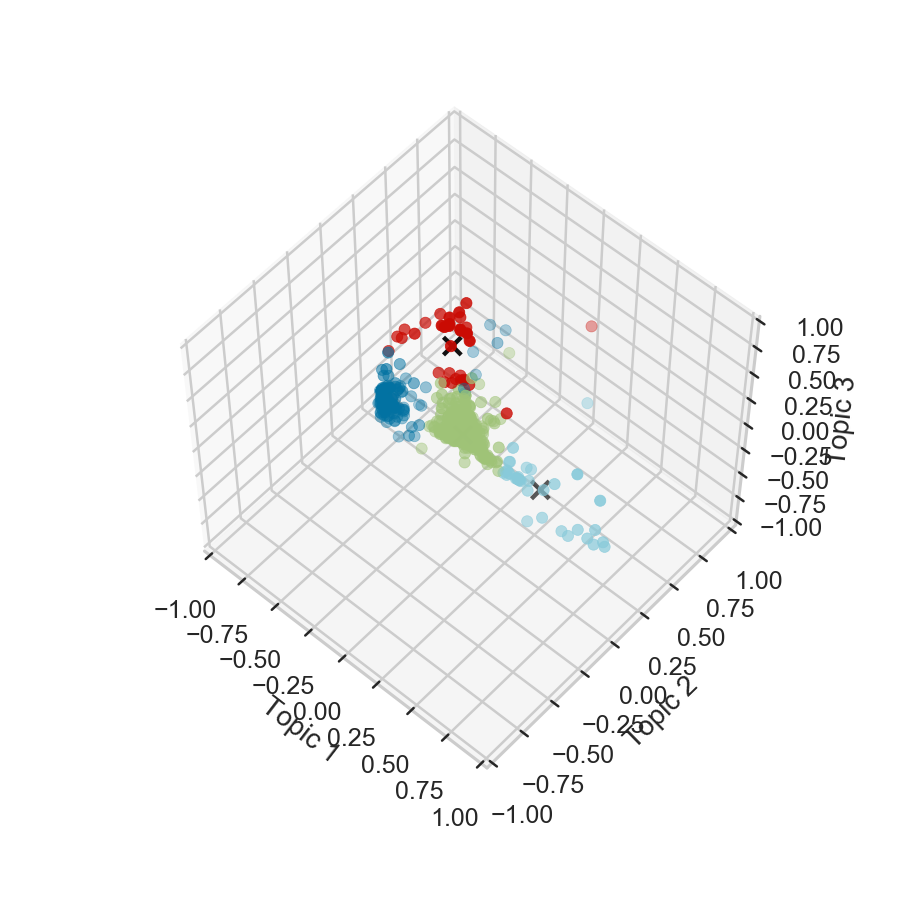

In [36]:
%matplotlib notebook
fig = plt.figure(figsize=(5,5)) #.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cluster_centers[1],cluster_centers[2],cluster_centers[3],\
           marker='x',s=50,c='k')
ax.scatter(df[1],df[2],df[3],c=col)
ax.set_xlabel('Topic 1')
ax.set_ylabel('Topic 2')
ax.set_zlabel('Topic 3')
ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
fig.show();

In [37]:
doc_topic = cv_doc_topic[2]
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=normalize(doc_topic)).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',normalize(doc_topic)[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [ 0.57553789 -0.17417648  0.05307372  0.66597189] color= r
248 : [ 0.62800349 -0.24513431  0.19547122  0.71225823] I bet those prehistoric cave artists would have loved to know how to draw better.
1130 : [ 0.57171119 -0.11241216 -0.02658388  0.81228266] The conversational nature of reality is the fact that whatever you desire of the world — whatever you desire of your partner in a marriage or a love relationship, whatever you desire of your children, whatever you desire of the people who work for you or with you, or your world — will not happen exactly as you would like it to happen. It's a form of affection and love that is now no longer extant, yeah?And then the third ritual: between all these fires are large piles of clothes. They were beautiful boots, I loved those boots, but they were finished after seven weeks of walking. ""The road seen, then not seenthe road seen, then not seenthe hillside hiding then revealing the way you should takethe road seen, then not